In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# build 3d dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution, as we will see. This problem is often referred to as `the curse of dimensionality`.

Fortunately, in real-world problems, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one. For example, consider the MNIST images: the pixels on the image borders are almost always white, so you could completely drop these pixels from the training set without losing much information. `Figure 7-6` confirms that these pixels are utterly unimportant for the classification task. Moreover, two neighboring pixels are often highly correlated: if you merge them into a single pixel (e.g., by taking the mean of the two pixel intensities), you will not lose much information.

> Reducing dimensionality does lose some information, so even though it will speed up training, it may also make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. So you should first try to train your system with the original data before considering using dimensionality reduction if training is too slow. In some cases, however, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance (but in general it won’t; it will just speed up training).

Apart from speeding up training, dimensionality reduction is also extremely useful for data visualization (or *DataViz*). Reducing the number of dimensions down to two (or three) makes it possible to plot a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters.

In this chapter we will discuss the curse of dimensionality and get a sense of what goes on in high-dimensional space. Then, we will present the two main approaches to dimensionality reduction (projection and Manifold Learning), and we will go through three of the most popular dimensionality reduction techniques: `PCA`, `Kernel PCA`, and `LLE`.

## 8.1 The Curse of Dimensionality
We are so used to living in three dimensions that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our mind (see `Figure 8-1`):
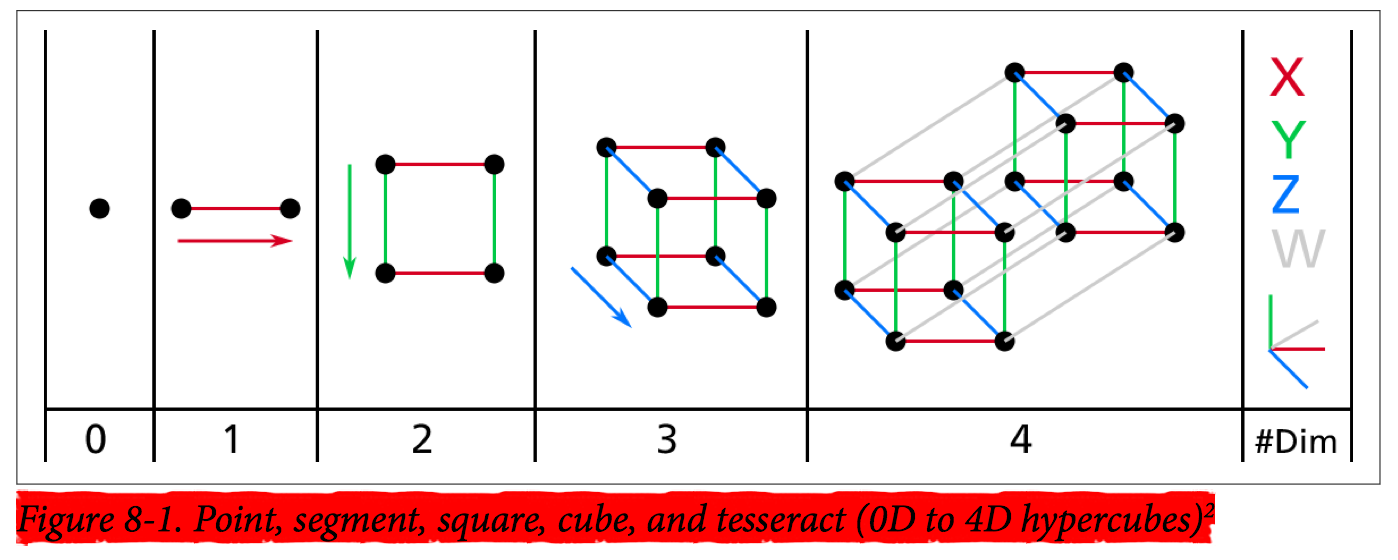

It turns out that many things behave very differently in high-dimensional space. For example, if you pick a random point in a unit square (a $1\times 1$ square), it will have only about a 0.4% chance of being located less than 0.001 from a border (in other words, it is very unlikely that a random point will be “extreme” along any dimension). But in a 10,000-dimensional unit hypercube (a $1\times 1\times ⋯ \times 1$ cube, with ten thousand 1s), this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border.

Here is a more troublesome difference: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1000000-dimensional hypercube? Well, the average distance, believe it or not, will be about 408.25 (roughly $\sqrt{\frac{1000000}{6}}$)! 

This is quite counterintuitive: how can two points be so far apart when they both lie within the same unit hypercube? This fact implies that highdimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. Of course, this also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it.

In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features (much less than in the MNIST problem), you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

## 8.2 Main Approaches for Dimensionality Reduction
Before we dive into specific dimensionality reduction algorithms, let’s take a look at the two main approaches to reducing dimensionality: `projection` and `Manifold Learning`.

### 8.2.1 Projection
In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated (as discussed earlier for MNIST). As a result, all training instances actually lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. 

This sounds very abstract, so let’s look at an example. In `Figure 8-2` you can see a 3D dataset represented by the circles:


Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space. Now if we project every training instance perpendicularly onto this subspace (as represented by the short lines connecting the instances to the plane), we get the new 2D dataset shown in `Figure 8-3`. We have just reduced the dataset’s dimensionality from 3D to 2D. Note that the axes correspond to new features $z_1$ and $z_2$ (the coordinates of the projections on the plane):
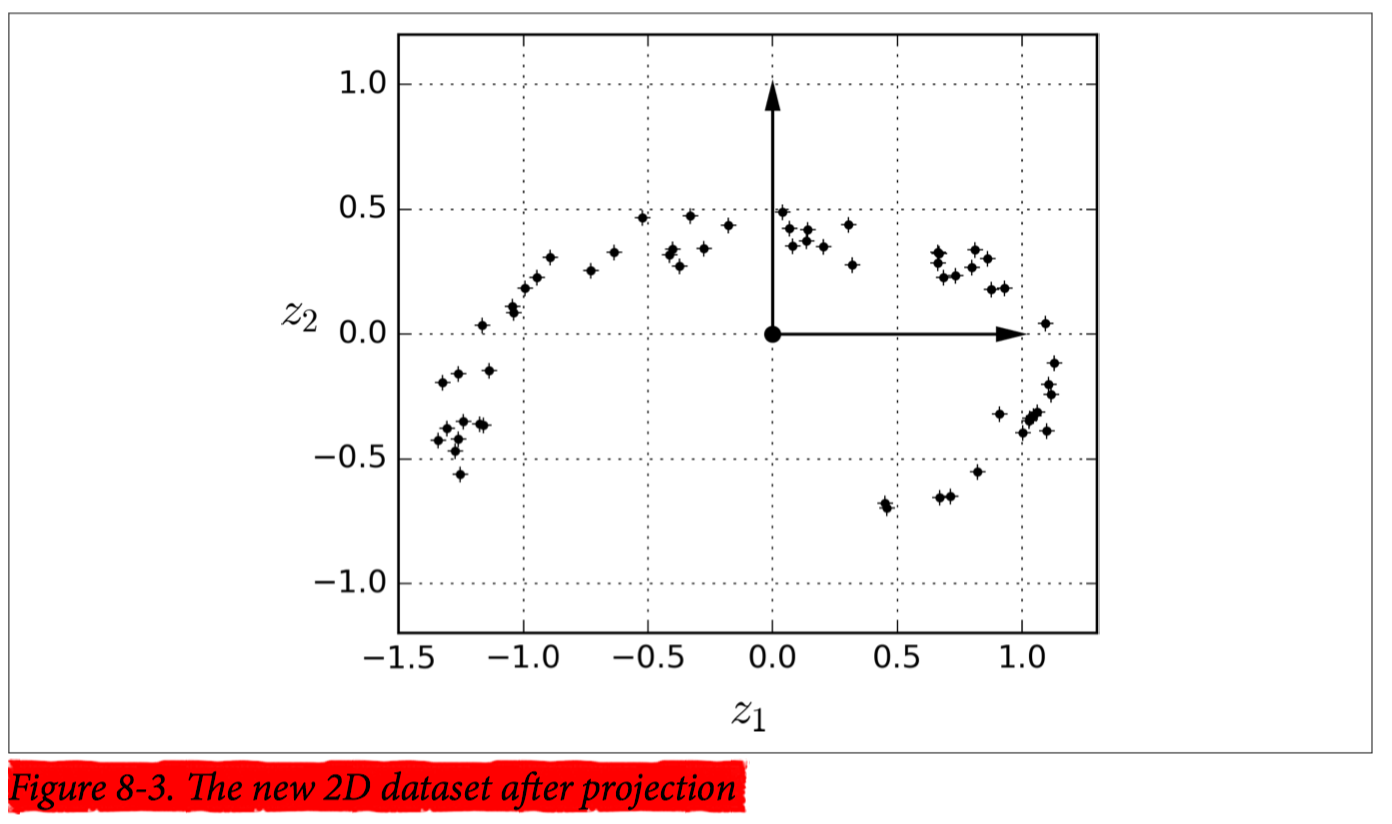

However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the famous `Swiss roll toy` dataset represented in `Figure 8-4`:


Simply projecting onto a plane (e.g., by dropping $x_3$) would squash different layers of the Swiss roll together, as shown on the left of `Figure 8-5`. However, what you really want is to unroll the Swiss roll to obtain the 2D dataset on the right of `Figure 8-5`:


### 8.2.2 Manifold Learning
The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss roll, $d = 2$ and $n = 3$: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called `Manifold Learning`. It relies on the manifold assumption, also called the `manifold hypothesis`, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

Once again, think about the MNIST dataset: all handwritten digit images have some similarities. They are made of connected lines, the borders are white, they are more or less centered, and so on. If you randomly generated images, only a ridiculously tiny fraction of them would look like handwritten digits. In other words, the degrees of freedom available to you if you try to create a digit image are dramatically lower than the degrees of freedom you would have if you were allowed to generate any image you wanted. These constraints tend to squeeze the dataset into a lowerdimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold. For example, in the top row of `Figure 8-6` the Swiss roll is split into two classes: in the 3D space (on the left), the decision boundary would be fairly complex, but in the 2D unrolled manifold space (on the right), the decision boundary is a simple straight line.



However, this assumption does not always hold. For example, in the bottom row of `Figure 8-6`, the decision boundary is located at $x_1 = 5$. This decision boundary looks very simple in the original 3D space (a vertical plane), but it looks more complex in the unrolled manifold (a collection of four independent line segments).

In short, if you reduce the dimensionality of your training set before training a model, it will definitely speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

Hopefully you now have a good sense of what the curse of dimensionality is and how dimensionality reduction algorithms can fight it, especially when the manifold assumption holds. The rest of this chapter will go through some of the most popular algorithms.

## 8.3 PCA
Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

### 8.3.1 Preserving the Variance
Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. 

For example, a simple 2D dataset is represented on the left of `Figure 8-7`, along with three different axes (i.e., one-dimensional hyperplanes). On the right is the result of the projection of the dataset onto each of these axes. As you can see, the projection onto the solid line preserves the maximum variance, while the projection onto the dotted line preserves very little variance, and the projection onto the dashed line preserves an intermediate amount of variance:
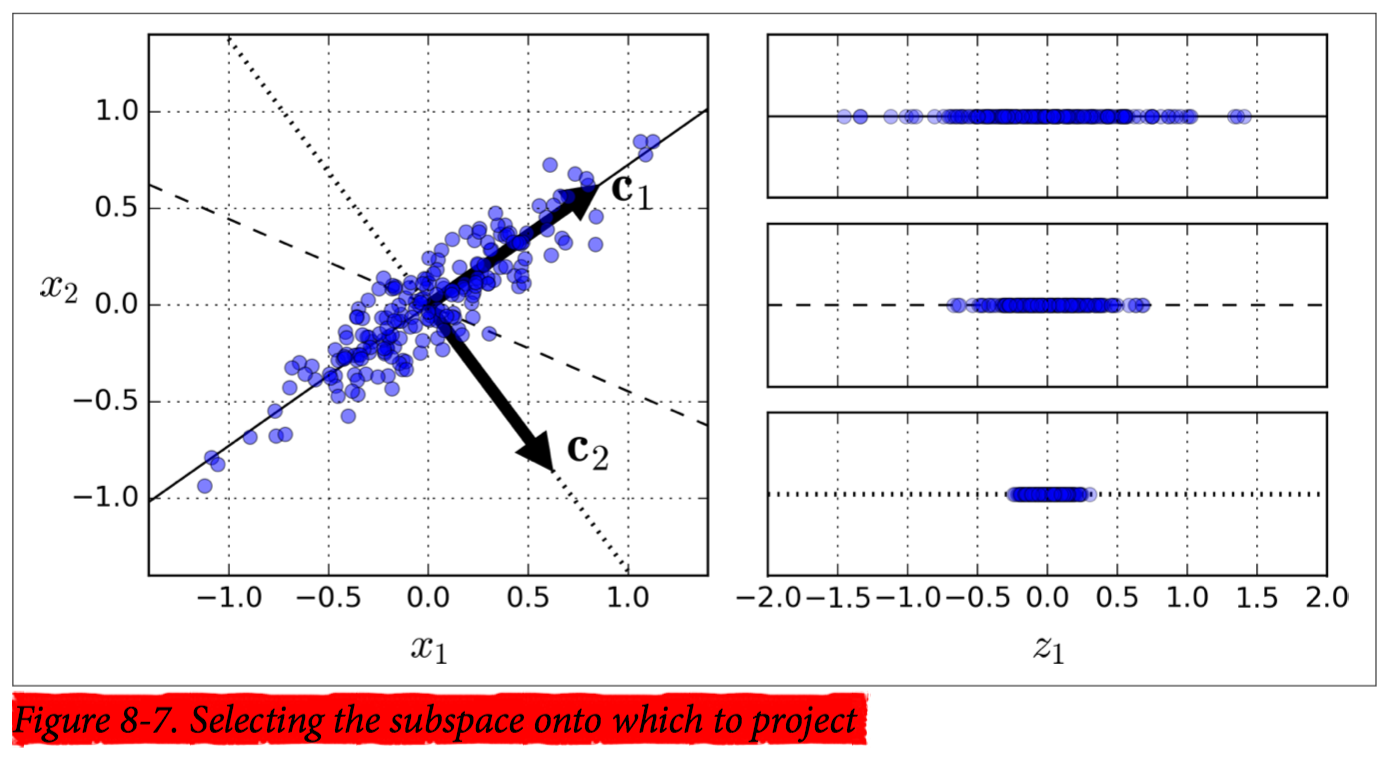

It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

### 8.3.2 Principal Components
PCA identifies the axis that accounts for the largest amount of variance in the training set. In `Figure 8-7`, it is the solid line. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. In this 2D example there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on--as many axes as the number of dimensions in the dataset.

The unit vector that defines the $i^{th}$ axis is called the $i^{th}$ principal component (PC). In `Figure 8-7`, the $1^{st}$ PC is $c_1$ and the $2^{nd}$ PC is $c^2$ . In `Figure 8-2` the first two PCs are represented by the orthogonal arrows in the plane, and the third PC would be orthogonal to the plane (pointing up or down).

> The direction of the principal components is not stable: if you perturb the training set slightly and run PCA again, some of the new PCs may point in the opposite direction of the original PCs. However, they will generally still lie on the same axes. In some cases, a pair of PCs may even rotate or swap, but the plane they define will generally remain the same.